# Определение возраста покупателей

Задача: создать и обучить модель, способную определить возраст по фото человека.
Для обучения модели в нашем распоряжении датасет из 7591 фотографий и данные по возрасту каждого из них.

План работ:
1. Проанализировать данные, возможно скорректировать план обучения
2. Создать функции загрузки данных, создания и обучения модели
3. Довести метрику МАЕ на тестовой выборке до минимальной (цель - не более 8)

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
labels = pd.read_csv('https://code.s3.yandex.net/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
labels.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


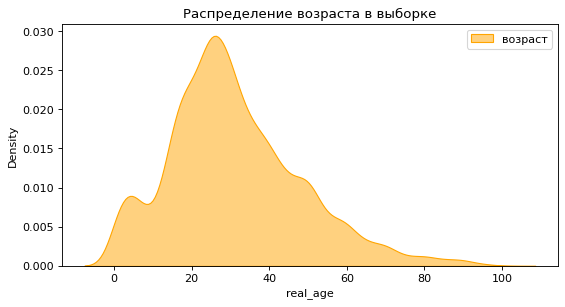

In [6]:
plt.figure(figsize=(8,4), dpi= 80)
sns.kdeplot(labels['real_age'], shade=True, color="orange", label='возраст', alpha=.5)

plt.title('Распределение возраста в выборке', fontsize=12)
plt.legend()
plt.show()

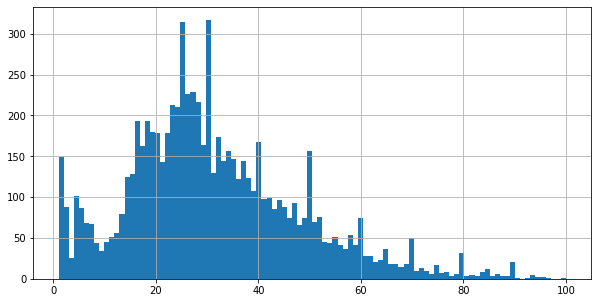

In [7]:
labels['real_age'].hist(bins=100, figsize=(10, 5));

Датасет содержит изображения людей возрастом от 1 до 100 лет с наибольшей концентрацией около 30 лет.

В датасете большинство возрастов сосредоточено в промежутке 10-60 лет, с явным пиком в диапазоне 25-30. Модели обучения будут склонны присваивать фотографиям возраст в этом диапазоне, т.к. в нем наибольшая вероятность "попасть" в диапазон с наименьшей ошибкой.

Также на гистограмме отчетливо видны пики на 25, 30, 40, 50 годах. Возможно, датасет содержит неточные данные, например размеченные с округлением.

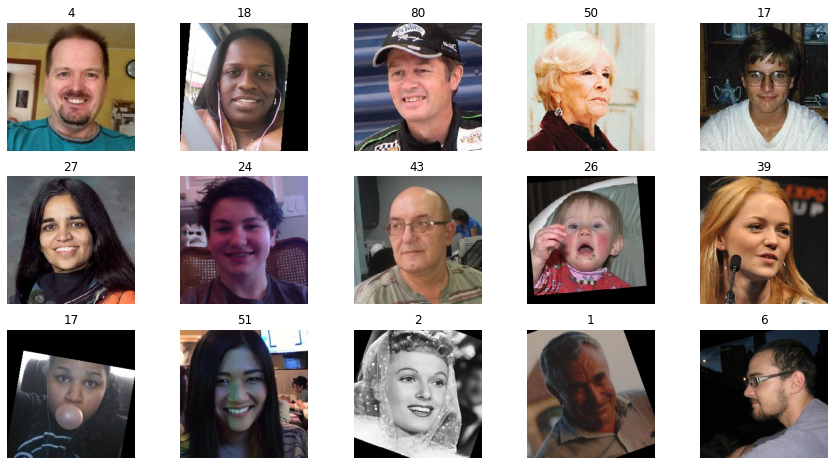

In [9]:
#выведем первые 15 изображений

fig = plt.figure(figsize=(15, 8))

for i in range(0, 15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(np.array(gen_flow[0][0][i]))
    plt.axis('off')
    plt.title(labels.loc[i, 'real_age'])

Изображения, сопоставленные с возрастом, заставляют усомниться в корректности разметки в большой части датасета. Минимум 6 из 15 выгруженных изображений размечены некорректно.

Исходя из специфики задачи аугментации с отражением по вертикали и вращением на 90 градусов вряд ли помогут, но однозначно можно попробовать отражение по горизонтали - так нейросеть лучше обучится.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

# загрузка обучающей выборки
def load_train(path):  
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow
    

def create_model (input_shape):
    model = Sequential()
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
    steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
    validation_data=test_data,
    batch_size=batch_size, epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=2)

    return model

```

Out:
```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 54s - loss: 198.2777 - mae: 10.2407 - val_loss: 404.7707 - val_mae: 15.1072
Epoch 2/10
356/356 - 40s - loss: 85.0085 - mae: 6.9952 - val_loss: 153.5863 - val_mae: 9.2041
Epoch 3/10
356/356 - 41s - loss: 58.2415 - mae: 5.8547 - val_loss: 77.5619 - val_mae: 6.4977
Epoch 4/10
356/356 - 41s - loss: 43.6552 - mae: 5.0369 - val_loss: 79.3576 - val_mae: 6.7920
Epoch 5/10
356/356 - 59s - loss: 32.9005 - mae: 4.3894 - val_loss: 83.0934 - val_mae: 6.6684
Epoch 6/10
356/356 - 63s - loss: 24.8397 - mae: 3.8085 - val_loss: 73.4131 - val_mae: 6.6112
Epoch 7/10
356/356 - 63s - loss: 20.2955 - mae: 3.4286 - val_loss: 74.3273 - val_mae: 6.5280
Epoch 8/10
356/356 - 67s - loss: 17.0835 - mae: 3.1382 - val_loss: 64.3206 - val_mae: 5.8664
Epoch 9/10
356/356 - 66s - loss: 14.4964 - mae: 2.8810 - val_loss: 69.9252 - val_mae: 6.4336
Epoch 10/10
356/356 - 64s - loss: 13.5116 - mae: 2.7896 - val_loss: 63.3813 - val_mae: 5.9695

```

## Анализ обученной модели

МАЕ итоговой модели = 5,97, что значительно лучше целевого значения = 8, что говорит о достаточной точности модели в опрделении возраста. В ходе работы надо проектом была реализована нейросеть на архитектуре ResNet50, опробованы разные версии параметров и подготовки данных. В одной их версий опробованы аугментации изображений, которые с точки зрения интуиции должны были улучшить метрики. Но по факту лучший результат показала модель без аугментаций, что, видимо, связано с самой архитектурой ResNet. Модель, показавшая наилучший результат, обученная на 10 эпохах:

```model = Sequential()
optimizer = Adam(lr=0.0001)
backbone = ResNet50(input_shape=input_shape,
                weights='imagenet',
                include_top=False)
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='relu')) 
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
```